In [1]:
#  Import libraries and define variables
import tensorflow as tf 
import pickle
import numpy as np
import os
import nibabel as nib
import matplotlib.pyplot as plt
from copy import deepcopy, copy
from tqdm import tqdm
import sys
sys.path.append('..')
import config


# Define the modalities and classifications
modalities = ['T1', 'T1GD', 'T2', 'FLAIR']
classifications = ['MGMT_positive', 'MGMT_negative']

# Define patch size and stride
block_h, block_w = 32, 32
stride = 2

# Interpolated image dimestions
inter_dim = (110, 90)

# Define paths to the BraTS dataset folders
path = config.MAIN_DIR

PATH = path + 'Data/'
Org_Dir = PATH + 'Original_Data_Backup/'
Work_Dir = PATH + 'Working_Data/'
Task_data = PATH + 'Task_data/'

# Loading the model
Model = tf.keras.models.load_model(path + 'Outputs/'+ 'latest_model.h5')

In [9]:
# Function Defination --> Arbitrary functions

def window(p, q, layer, flair_data):
    W = flair_data[p:p+32, q:q+32, layer]
    return W


def ML_function(Windows, layer):
    count = 0
    X = np.array(Windows).reshape(-1, block_h, block_w, 1)
    predicted_classes = np.argmax(Model(X), axis=1)
    for val in predicted_classes:
        if (val == 1):
            count = count + 1
    # print(count)
    return count


def fun(a, b, layer, flair_data):
    if (a < 0 or a > 239 or b < 0 or b > 239):
        print("invalid point")
        return 0
    else:
        Windows = []
        for x in range(a-31, a+1):
            for y in range(b-31, b+1):
                Windows.append(window(x, y, layer, flair_data))
        count_1 = ML_function(Windows, layer)
    return (count_1/1024)


In [10]:
# Function Defination --> Importing the weighted matrix and averaging the various modalities

def Average_Weighted_Matrix():
    taskdata =os.listdir(Task_data)
    if '.DS_Store' in taskdata:
        taskdata.remove('.DS_Store')
    for type in taskdata:
        typedir = os.path.join(Task_data, type + '/')
        typedata = os.listdir(typedir)
        if '.DS_Store' in typedata:
            typedata.remove('.DS_Store')
        for patient in tqdm(typedata):
            patientdir = os.path.join(typedir, patient + '/')
            os.chdir(patientdir)
            # print(patientdir)

            # Loading the weighted matrix for each modality
            with open(patientdir + 'W_M_{}_{}.pickle'.format(patient, modalities[0]), 'rb') as f:
                try:
                    W_M_t1 = pickle.load(f)
                except EOFError:
                    W_M_t1 = None

            with open(patientdir + 'W_M_{}_{}.pickle'.format(patient, modalities[1]), 'rb') as f:
                try:
                    W_M_t1ce = pickle.load(f)
                except EOFError:
                    W_M_t1ce = None

            with open(patientdir + 'W_M_{}_{}.pickle'.format(patient, modalities[2]), 'rb') as f:
                try:
                    W_M_t2 = pickle.load(f)
                except EOFError:
                    W_M_t2 = None

            with open(patientdir + 'W_M_{}_{}.pickle'.format(patient, modalities[3]), 'rb') as f:
                try:
                    W_M_flair = pickle.load(f)
                except EOFError:
                    W_M_flair = None

            # Averaging the weighted matrix
            valid_modalities = sum(x is not None for x in [
                                W_M_t1, W_M_t1ce, W_M_t2, W_M_flair])
            W_M_sum = np.zeros_like(W_M_t1)
            if W_M_t1 is not None:
                W_M_sum += W_M_t1
            if W_M_t1ce is not None:
                W_M_sum += W_M_t1ce
            if W_M_t2 is not None:
                W_M_sum += W_M_t2
            if W_M_flair is not None:
                W_M_sum += W_M_flair
            W_M = W_M_sum / valid_modalities

            # Storing the averaged weighted matrix
            with open(patientdir + '/W_M_{}_mod_average.pickle'.format(patient), 'wb') as f:
                pickle.dump(W_M, f)


In [11]:
# Function Defination --> Generated Weighted matrix

def Generate_Weighted_Matrix(modality):
    taskdir = os.listdir(Task_data)
    if '.DS_Store' in taskdir:
        taskdir.remove('.DS_Store')
    for type in taskdir:
        # print(type)
        Type_path = os.path.join(Task_data, type + '/')
        typepath = os.listdir(Type_path)
        if '.DS_Store' in typepath:
            typepath.remove('.DS_Store')
        for patient in typepath:
            # print(patient)
            Patient_path = os.path.join(Type_path, patient + '/')
            os.chdir(Patient_path)
            Mod = nib.load('{}_{}.nii.gz'.format(patient, modality)) # Loading the flair image
            Mod_data = Mod.get_fdata()

            # Normalizing the image
            for l in range(0, Mod_data.shape[2]):
                if ((Mod_data[:,:,l].max()) == 0):
                  continue
                else:
                    Mod_data[:,:,l] *= (255.0/Mod_data[:,:,l].max())
                
            seg_mask = nib.load('{}_seg.nii.gz'.format(patient)) # Loading the segmentation mask
            seg_mask_data = seg_mask.get_fdata()

            # Extracting only those layers from mask which have non zero values
            z = np.any(seg_mask_data, axis=(0, 1))
            nonzero_layers = np.nonzero(z)
            nonzero_layer_indices = nonzero_layers[0]
            num_layers = nonzero_layer_indices.size
            #print(num_layers)
            arr = np.zeros((240,240,num_layers))
            layer_num = 0

            # Select the layer with maximum pixels

            
            #Finding indices of cancer pixels using mask data
            for layer in nonzero_layer_indices:
                indices = np.transpose(np.nonzero(seg_mask_data[:,:,layer]))
                #print(indices, layer)
                for [a,b] in indices:
                    arr[a,b,layer_num] = fun(a,b,layer,Mod_data)
                layer_num = layer_num + 1
                
            #print(np.count_nonzero(np.any(arr, axis=(0, 1))))
            
            #Calculating weighted average                
            Weighted_matrix = np.zeros((240,240))
            for x in range (0,240):
                for y in range (0,240):
                    Sum = 0
                    num_terms = 0
                    for slice_num in range (0,num_layers):
                        if(arr[x][y][slice_num] != 0):
                            Sum = Sum + arr[x][y][slice_num]
                            num_terms = num_terms + 1
                    if(num_terms != 0):
                        Weighted_matrix[x][y] = Sum/num_terms
            print(Weighted_matrix.shape)

            #Storing Wiegted Average Matrix of the patient
            pickle_out = open(Patient_path + '/W_M_{}_{}.pickle'.format(patient, modality), 'wb')
            pickle.dump(Weighted_matrix, pickle_out)
            pickle_out.close()

In [12]:
# Main cell to invoke functions

# Function call to generate weighted matrix
for modality in modalities:
    print(f'Calculating weighted matrix for {modality}')
    Generate_Weighted_Matrix(modality)

# Function call to average the weighted matrix
Average_Weighted_Matrix()

os.system('say "your program has finished"')

Calculating weighted matrix for T1
(240, 240)
(240, 240)
(240, 240)
(240, 240)
Calculating weighted matrix for T1GD
(240, 240)
(240, 240)
(240, 240)
(240, 240)
Calculating weighted matrix for T2
(240, 240)
(240, 240)
(240, 240)
(240, 240)
Calculating weighted matrix for FLAIR
(240, 240)
(240, 240)
(240, 240)
(240, 240)


100%|██████████| 2/2 [00:00<00:00, 19.25it/s]


1

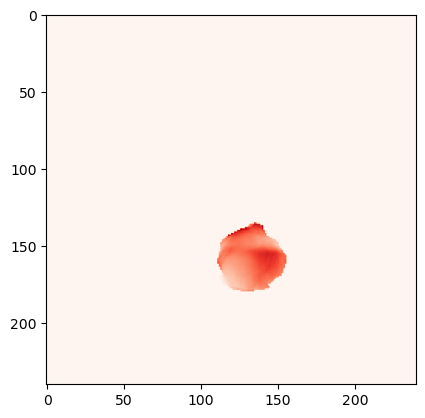

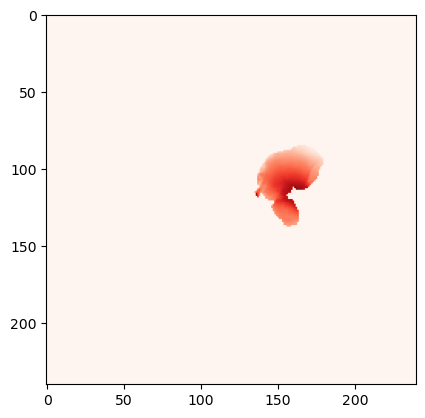

In [2]:
# Displaying the weighted matrix

pickle_in_positive = open(
    'D:/MGMT research project/Data/Task_data/MGMT_negative/UPENN-GBM-00604_11/W_M_UPENN-GBM-00604_11_mod_average.pickle', 'rb')
pickle_in_negative = open(
    'D:/MGMT research project/Data/Task_data/MGMT_positive/UPENN-GBM-00588_11/W_M_UPENN-GBM-00588_11_mod_average.pickle', 'rb')

W_M_positive = pickle.load(pickle_in_positive)
W_M_negative = pickle.load(pickle_in_negative)

plt.imshow(W_M_positive, cmap='Reds')
plt.show()

plt.imshow(W_M_negative, cmap='Reds')
plt.show()